In [14]:
import json
import plotly
import pandas as pd
import numpy as np

from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re

from flask import Flask
from flask import render_template, request, jsonify
#from plotly.graph_objects import Bar
from plotly import graph_objects
import plotly.express as px

import joblib
from sqlalchemy import create_engine

import spacy
import en_core_web_sm

from src.data_processing.process_data import create_named_entities_feature

In [42]:
engine = create_engine('sqlite:///../data/DisasterTweets.db')
df = pd.read_sql_table('categorized_messages', engine)

# Drop columns 'original', and 'id' as we don't need them at this stage
df.drop(columns=['original', 'id'], inplace=True)

df.head()

,message,genre,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,...,entity_ORG,entity_GPE,entity_LOC,entity_PRODUCT,entity_EVENT,entity_LANGUAGE,entity_DATE,entity_TIME,entity_MONEY,translated
0,Weather update - a cold front from Cuba that c...,direct,1,0,0,0,0,0,0,0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,Is the Hurricane over or is it not over,direct,1,0,0,1,0,0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,Looking for someone but no name,direct,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1,1,0,1,0,1,0,0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,"says: west side of Haiti, rest of the country ...",direct,1,0,0,0,0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1


In [46]:
possible_feature_columns = ['message',
                                'translated',
                                'entity_PERSON',
                                'entity_NORP',
                                'entity_FAC',
                                'entity_ORG',
                                'entity_GPE',
                                'entity_LOC',
                                'entity_PRODUCT',
                                'entity_EVENT',
                                'entity_LANGUAGE',
                                'entity_DATE',
                                'entity_TIME',
                                'entity_MONEY']

# Keep any columns that match our allowed column list for features
# and keep any columns that DON'T match for the labels
features = df.loc[:, df.columns[df.columns.isin(possible_feature_columns)]]
labels = df.loc[:, df.columns[~df.columns.isin(possible_feature_columns)]].drop(columns=['genre'])
category_names = labels.columns

In [47]:
entities_of_interest = ['entity_PERSON',
                        'entity_NORP',
                        'entity_FAC',
                        'entity_ORG',
                        'entity_GPE',
                        'entity_LOC',
                        'entity_PRODUCT',
                        'entity_EVENT',
                        'entity_LANGUAGE',
                        'entity_DATE',
                        'entity_TIME',
                        'entity_MONEY']

# TODO: need to figure out how I can access labels and features from training data...
labels.loc[:, 'message index'] = labels.index

labels_melted = labels.melt(id_vars=['message index'],
                            value_vars=list(
    labels.columns.drop(['message index'])),
    var_name='category',
    value_name='category membership')


In [48]:
labels_melted.

,message index,category,category membership
0,0,related,1
1,1,related,1
2,2,related,1
3,3,related,1
4,4,related,1
...,...,...,...
943735,26210,direct_report,0
943736,26211,direct_report,0
943737,26212,direct_report,0
943738,26213,direct_report,0


In [64]:
# Do the heavy lifting of calculating the data for showing fractions of messages per label/category
# in pandas and python, so javascript doesn't have to do it via plotly histogram when in web app

category_message_counts = pd.DataFrame(labels_melted.groupby('category')[
                                       'category membership']
                                       .sum())\
    .reset_index().sort_values('category membership', ascending=False)
category_message_counts.rename(columns={'category membership': 'Messages in This Category',
                                       'category': 'Category'}, inplace=True)
category_message_counts['Messages Not in This Category'] = \
len(df) - category_message_counts['Messages in This Category']

category_message_counts

,Category,Messages in This Category,Messages Not in This Category
25,related,20093,6122
1,aid_related,10860,15355
35,weather_related,7297,18918
7,direct_report,5075,21140
26,request,4474,21741
21,other_aid,3446,22769
12,food,2923,23292
8,earthquake,2455,23760
31,storm,2443,23772
29,shelter,2314,23901


In [80]:
dir(px.colors.sequential)
#dir(px.colors.cyclical)
#dir(px.colors.diverging)

['Aggrnyl',
 'Agsunset',
 'Blackbody',
 'Bluered',
 'Blues',
 'Blugrn',
 'Bluyl',
 'Brwnyl',
 'BuGn',
 'BuPu',
 'Burg',
 'Burgyl',
 'Cividis',
 'Darkmint',
 'Electric',
 'Emrld',
 'GnBu',
 'Greens',
 'Greys',
 'Hot',
 'Inferno',
 'Jet',
 'Magenta',
 'Magma',
 'Mint',
 'OrRd',
 'Oranges',
 'Oryel',
 'Peach',
 'Pinkyl',
 'Plasma',
 'Plotly3',
 'PuBu',
 'PuBuGn',
 'PuRd',
 'Purp',
 'Purples',
 'Purpor',
 'Rainbow',
 'RdBu',
 'RdPu',
 'Redor',
 'Reds',
 'Sunset',
 'Sunsetdark',
 'Teal',
 'Tealgrn',
 'Viridis',
 'YlGn',
 'YlGnBu',
 'YlOrBr',
 'YlOrRd',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_swatches',
 'algae',
 'amp',
 'deep',
 'dense',
 'gray',
 'haline',
 'ice',
 'matter',
 'solar',
 'speed',
 'swatches',
 'tempo',
 'thermal',
 'turbid']

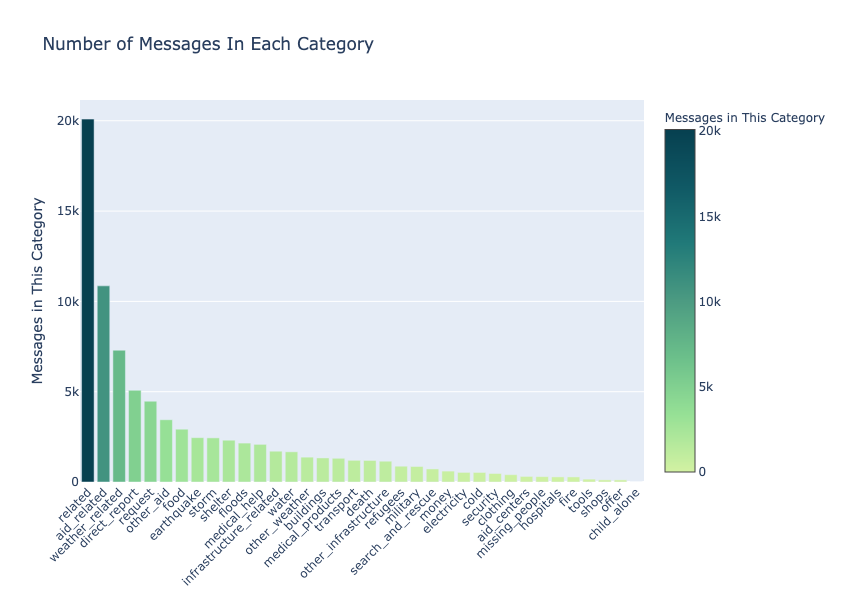

In [97]:
fig = px.bar(category_message_counts, y='Messages in This Category', x='Category',  # facet_col='category',
                     color='Messages in This Category',
             color_continuous_scale='Emrld',
                     barmode='relative', #barnorm='fraction',
                     #color_discrete_map={0: 'crimson', 1: 'royalblue'},
                     title='Number of Messages In Each Category')

fig.update_layout(xaxis=graph_objects.layout.XAxis(
        tickangle=-45))
fig

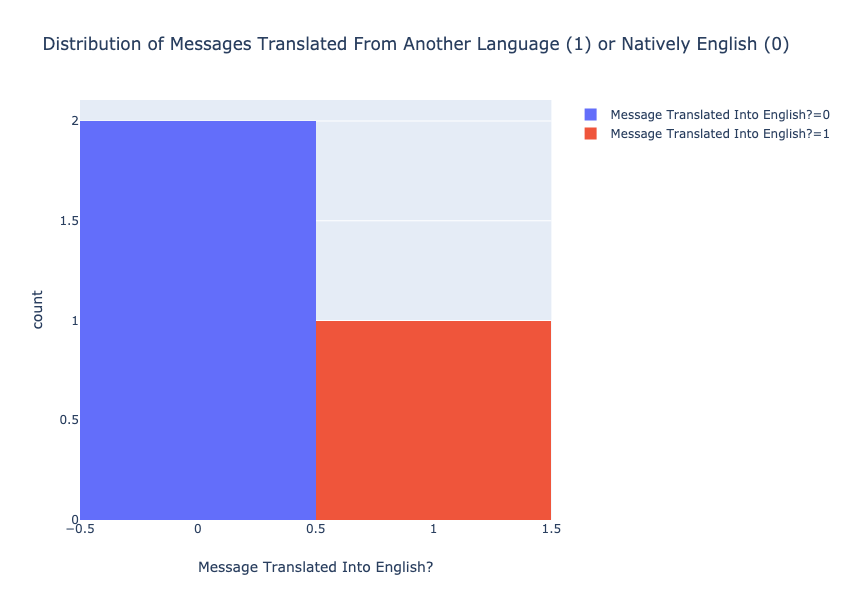

In [6]:
fig = px.histogram(df, x='translated', color='translated',
                  labels={'translated': 'Message Translated Into English?',
                           'count': 'Number of Messages'},
                    title='Distribution of Messages Translated From Another Language (1) or Natively English (0)')
fig.show()

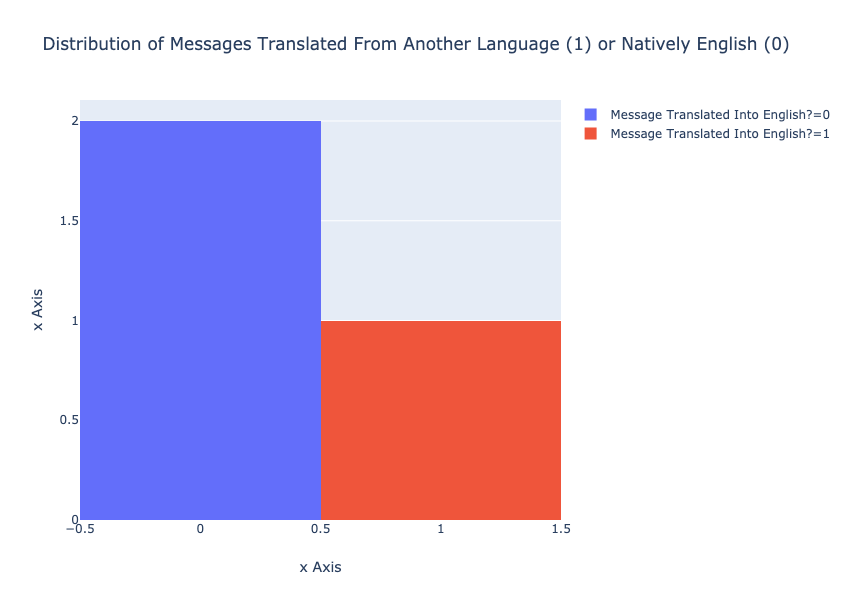

In [13]:
fig.update_layout(yaxis=graph_objects.layout.YAxis(
        title=graph_objects.layout.yaxis.Title(
            text="x Axis")))

In [99]:
melted_entities

,message,entity type,count
0,Weather update - a cold front from Cuba that c...,PERSON,0.0
1,Is the Hurricane over or is it not over,PERSON,0.0
2,Looking for someone but no name,PERSON,0.0
3,UN reports Leogane 80-90 destroyed. Only Hospi...,PERSON,0.0
4,"says: west side of Haiti, rest of the country ...",PERSON,0.0
...,...,...,...
314575,The training demonstrated how to enhance micro...,MONEY,0.0
314576,A suitable candidate has been selected and OCH...,MONEY,0.0
314577,"Proshika, operating in Cox's Bazar municipalit...",MONEY,0.0
314578,"Some 2,000 women protesting against the conduc...",MONEY,0.0


In [103]:
melted_entities = features.melt(id_vars=['message'],
                                value_vars=entities_of_interest,
                                var_name='entity type',
                                value_name='count')

# Remove "entity_" from start of each entity type value
melted_entities['entity type'] = melted_entities['entity type'].str.slice(
    7,)

melted_entities_bar = melted_entities.groupby('entity type',
                                              as_index=False)['count'].sum().sort_values('count',
                                                                                         ascending=False)
melted_entities_bar.rename(columns={'entity type': 'Named Entity Type',
                           'count': 'Number of Entities in Corpus'},
                          inplace=True)

melted_entities_bar

,Named Entity Type,Number of Entities in Corpus
8,ORG,10973.0
3,GPE,10116.0
0,DATE,6994.0
9,PERSON,3810.0
7,NORP,1962.0
5,LOC,1403.0
6,MONEY,1142.0
11,TIME,1091.0
2,FAC,687.0
10,PRODUCT,256.0


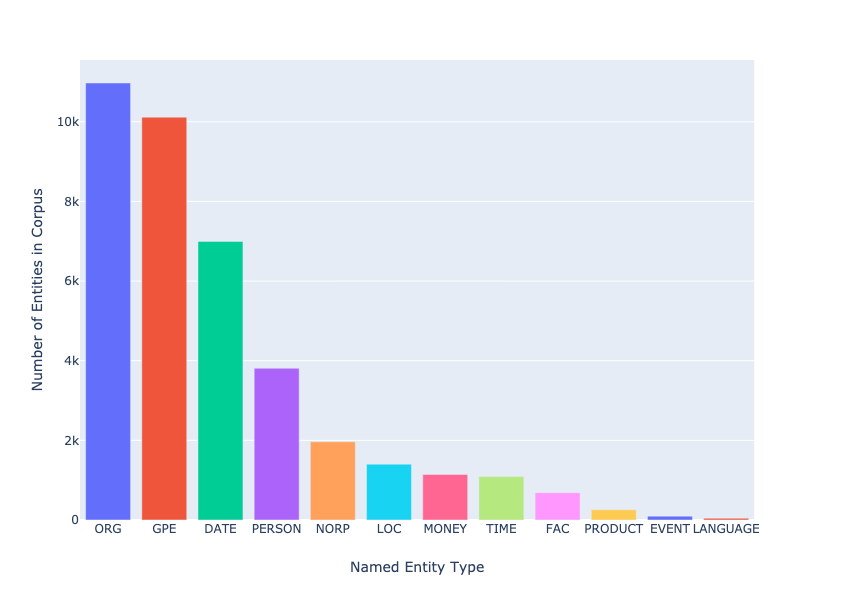

In [107]:
fig = px.bar(melted_entities_bar,
              y='Number of Entities in Corpus', 
             x='Named Entity Type', 
             color='Named Entity Type').update_layout(showlegend=False)

fig